In [6]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model

In [10]:
df = pd.read_csv("C:\\Users\\aadit\\CNN-LSTM-GRU\\kaggle\\input\\edgeiiotset-cyber-security-dataset-of-iot-iiot\\Edge-IIoTset dataset\Selected dataset for ML and DL\\DNN-EdgeIIoT-dataset.csv", low_memory = False)

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\aadit\AppData\Local\Temp\ipykernel_34952\3233320833.py:1: SyntaxWarning: invalid escape sequence '\S'
  df = pd.read_csv("C:\\Users\\aadit\\CNN-LSTM-GRU\\kaggle\\input\\edgeiiotset-cyber-security-dataset-of-iot-iiot\\Edge-IIoTset dataset\Selected dataset for ML and DL\\DNN-EdgeIIoT-dataset.csv", low_memory = False)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2219201 entries, 0 to 2219200
Data columns (total 63 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   frame.time                 object 
 1   ip.src_host                object 
 2   ip.dst_host                object 
 3   arp.dst.proto_ipv4         object 
 4   arp.opcode                 float64
 5   arp.hw.size                float64
 6   arp.src.proto_ipv4         object 
 7   icmp.checksum              float64
 8   icmp.seq_le                float64
 9   icmp.transmit_timestamp    float64
 10  icmp.unused                float64
 11  http.file_data             object 
 12  http.content_length        float64
 13  http.request.uri.query     object 
 14  http.request.method        object 
 15  http.referer               object 
 16  http.request.full_uri      object 
 17  http.request.version       object 
 18  http.response              float64
 19  http.tls_port              float64
 20  tc

In [12]:
print(df['Attack_type'].value_counts())

Attack_type
Normal                   1615643
DDoS_UDP                  121568
DDoS_ICMP                 116436
SQL_injection              51203
Password                   50153
Vulnerability_scanner      50110
DDoS_TCP                   50062
DDoS_HTTP                  49911
Uploading                  37634
Backdoor                   24862
Port_Scanning              22564
XSS                        15915
Ransomware                 10925
MITM                        1214
Fingerprinting              1001
Name: count, dtype: int64


In [13]:
# Creating a dictionary of Types
attacks = {'Normal': 0,'MITM': 1, 'Uploading': 2, 'Ransomware': 3, 'SQL_injection': 4,
       'DDoS_HTTP': 5, 'DDoS_TCP': 6, 'Password': 7, 'Port_Scanning': 8,
       'Vulnerability_scanner': 9, 'Backdoor': 10, 'XSS': 11, 'Fingerprinting': 12,
       'DDoS_UDP': 13, 'DDoS_ICMP': 14}
df['Attack_type'] = df['Attack_type'].map(attacks)

In [14]:
X = df.drop(columns=['Attack_label', 'Attack_type'])
y = df['Attack_label']

In [19]:
# Apply the Chi-Squared test
X = X.select_dtypes(include=[np.number])
chi_selector = SelectKBest(chi2, k='all')  # Set k to the desired number of features
X_kbest = chi_selector.fit_transform(X, y)

In [20]:
# Get the scores for each feature
chi_scores = chi_selector.scores_

# Combine scores with feature names
chi_scores = pd.DataFrame({'feature': X.columns, 'score': chi_scores})

# Sort the features by their scores
chi_scores = chi_scores.sort_values(by='score', ascending=False)

print(chi_scores)

                      feature         score
10                tcp.ack_raw  1.620400e+14
9                     tcp.ack  7.995480e+13
20                    tcp.seq  7.141371e+12
22                 udp.stream  4.273613e+11
24               dns.qry.name  4.380512e+10
4     icmp.transmit_timestamp  1.709412e+10
3                 icmp.seq_le  1.124575e+10
2               icmp.checksum  1.027802e+10
16                tcp.dstport  6.401918e+09
11               tcp.checksum  2.585162e+09
6         http.content_length  2.856330e+07
21                   udp.port  2.375208e+07
19                    tcp.len  1.310122e+07
32              mqtt.hdrflags  9.924011e+06
33                   mqtt.len  1.643743e+06
17                  tcp.flags  1.438213e+06
37             mqtt.topic_len  7.442977e+05
35               mqtt.msgtype  6.202507e+05
25                 dns.qry.qu  1.936297e+05
23             udp.time_delta  1.915608e+05
36             mqtt.proto_len  1.240780e+05
38                   mqtt.ver  1

In [21]:
selected_features = chi_scores['feature'].tolist()[:93]  # Select top k features

In [22]:
# Split the data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# Split the training data further into train (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [45]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

print("y_train shape:", y_train.shape)

X_train shape: (1553440, 42)
X_val shape: (221920, 42)
X_test shape: (443841, 42)
y_train shape: (1553440,)


In [25]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [46]:
def cnn_lstm_model(input_shape, num_classes):
    
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),        
        MaxPooling1D(pool_size=2),
        
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        
        LSTM(64, return_sequences=False),
        
        
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (X_train.shape[1], 1)
num_classes = 1
model = cnn_lstm_model(input_shape, num_classes)
model.summary()
plot_model(model)

c:\Users\aadit\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 40, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 18, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,809 (186.75 KB)

 Trainable params: 47,809 (186.75 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [47]:
train_start_time = time.time()
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=6, batch_size=32)
# Record the ending time
train_end_time = time.time()

# Record the starting time for testing
test_start_time = time.time()
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)
# Record the ending time for testing
test_end_time = time.time()

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Calculate and print the training time
train_time = train_end_time - train_start_time
print(f"Training time: {train_time:.2f} seconds")

# Calculate and print the testing time
test_time = test_end_time - test_start_time
print(f"Testing time: {test_time:.2f} seconds")

Epoch 1/6


KeyboardInterrupt: 

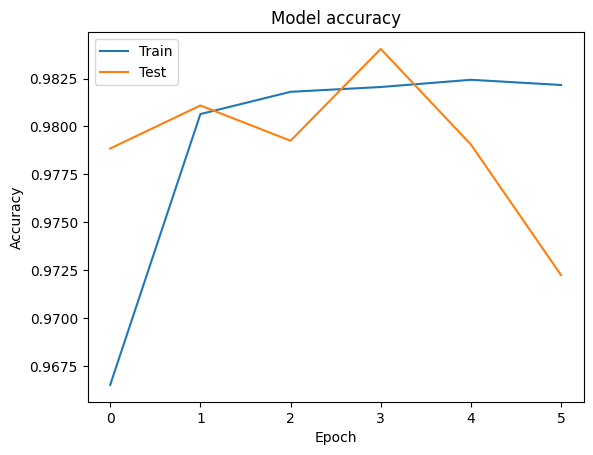

<Figure size 640x480 with 0 Axes>

In [36]:
# Plot the training and validation accuracy over the epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig('acc_plo.jpg')

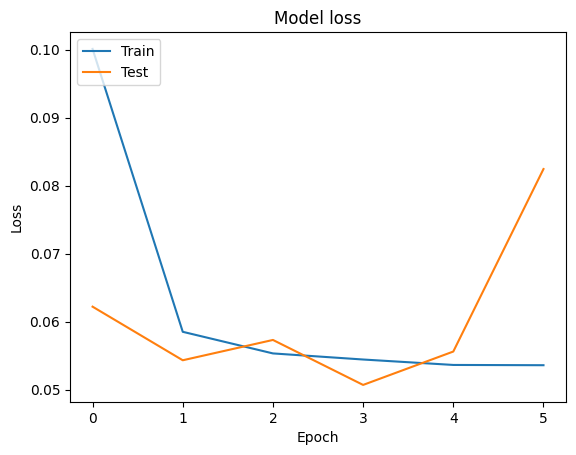

<Figure size 640x480 with 0 Axes>

In [37]:
# Plot the training and validation loss over the epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.savefig('los_plo.jpg')

In [38]:
y_pred = model.predict(np.expand_dims(X_test, axis=2))

13871/13871 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step


In [39]:
# Performance comparison table
print(classification_report(y_test, np.round(y_pred), target_names=['No Intrusion', 'Intrusion']))

              precision    recall  f1-score   support

No Intrusion       0.97      1.00      0.98    323305
   Intrusion       0.99      0.90      0.95    120536

    accuracy                           0.97    443841
   macro avg       0.98      0.95      0.96    443841
weighted avg       0.97      0.97      0.97    443841



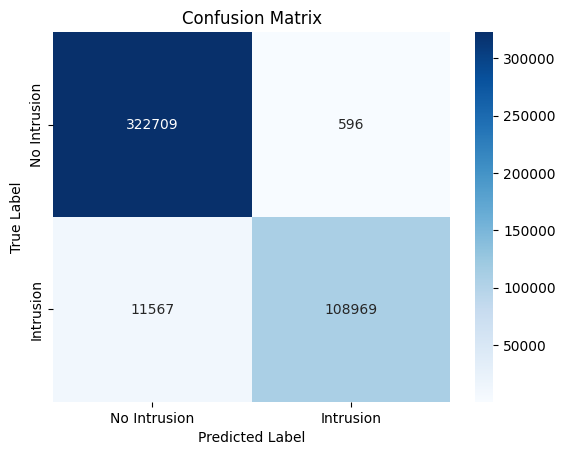

<Figure size 640x480 with 0 Axes>

In [40]:
# Compute the confusion matrix
conf_mat = confusion_matrix(y_test, np.round(y_pred))

# Define the class labels
class_labels = ['No Intrusion', 'Intrusion']

# Create a heatmap plot of the confusion matrix
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Set the plot labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()
plt.savefig('con_max.jpg')

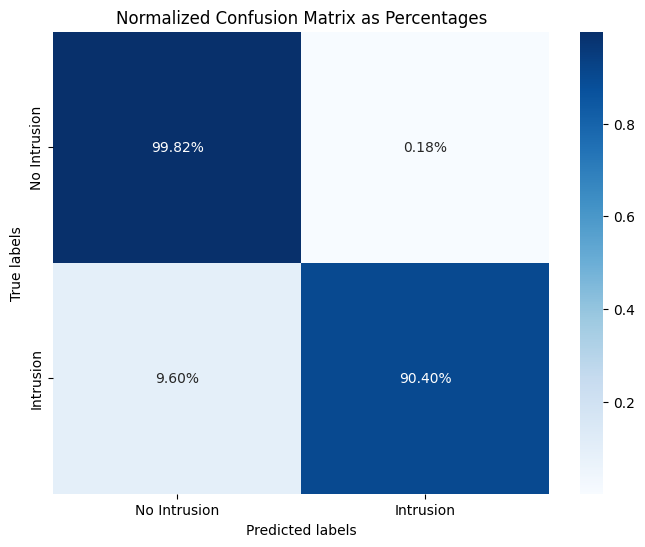

<Figure size 640x480 with 0 Axes>

In [41]:
# Predict the test set
y_pred = (y_pred > 0.5)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# Define the class labels
class_labels = ['No Intrusion', 'Intrusion']
# Print confusion matrix as heatmap with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, fmt='.2%')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix as Percentages')
plt.show()
plt.savefig('con_per.jpg')